In [12]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_samples_per_class = 500  # 500 risky + 500 non-risky = 1000 total

# Generate non-risky samples (sids_risk = 0)
non_risky_data = {
    'heart_rate': np.random.normal(140, 10, n_samples_per_class),  # within 110–170
    'temperature': np.random.normal(37, 0.4, n_samples_per_class),
    'motion_duration': np.random.exponential(10, n_samples_per_class),
    'no_motion_duration': np.random.exponential(20, n_samples_per_class)  # < 60
}
non_risky_df = pd.DataFrame(non_risky_data)
non_risky_df['sids_risk'] = 0

# Generate risky samples (sids_risk = 1)
risky_heart_rate = np.concatenate([
    np.random.normal(100, 5, n_samples_per_class // 2),  # below 110
    np.random.normal(180, 5, n_samples_per_class // 2)   # above 170
])
risky_data = {
    'heart_rate': risky_heart_rate,
    'temperature': np.random.normal(37, 0.4, n_samples_per_class),
    'motion_duration': np.random.exponential(10, n_samples_per_class),
    'no_motion_duration': np.random.exponential(80, n_samples_per_class) + 60  # > 60
}
risky_df = pd.DataFrame(risky_data)
risky_df['sids_risk'] = 1

# Combine both into a single balanced dataset
df = pd.concat([non_risky_df, risky_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the data

# Display class balance and a sample
print("Class distribution:\n", df['sids_risk'].value_counts())
print("\nSample data:")
print(df.head())

# Save to CSV
df.to_csv('sids_risk_data_balanced.csv', index=False)


Class distribution:
 sids_risk
1    500
0    500
Name: count, dtype: int64

Sample data:
   heart_rate  temperature  motion_duration  no_motion_duration  sids_risk
0  102.543625    36.926721         6.691071           63.277332          1
1   93.455898    36.874588        13.205070          111.917592          1
2  109.002556    37.168038        17.202634          101.061192          1
3  101.885502    37.117690        32.568977           62.082031          1
4  128.753579    37.087660         2.433950           39.086746          0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = df.drop(['sids_risk'], axis=1)  # Drop sids_risk AND resp_rate
y = df['sids_risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



Random Forest Models

In [13]:
print("\n--- Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))



--- Random Forest ---
Accuracy: 0.985
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.98      0.99      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



Logistic Regression

In [14]:
print("\n--- Logistic Regression ---")
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))



--- Logistic Regression ---
Accuracy: 0.655
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       100
           1       0.70      0.55      0.61       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



SVM(Support Vector Machine)

In [15]:
print("\n--- Support Vector Machine ---")
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))



--- Support Vector Machine ---
Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.96      0.99      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



In [16]:
import joblib

# Save model
joblib.dump(model, 'sids_risk_detector.pkl')

['sids_risk_detector.pkl']

To Load the model

In [17]:
model = joblib.load('sids_risk_detector.pkl')


Visualizing the features

C:\Users\Ab\AppData\Local\Temp\ipykernel_17256\3092367508.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


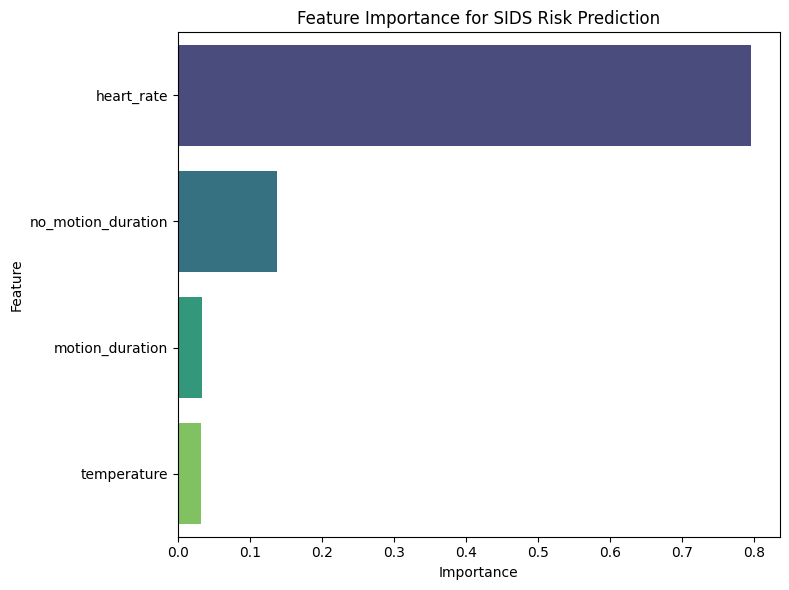

In [18]:
# Visualize feature importance
importances = model.feature_importances_
feature_names = X.columns  # X already has 'resp_rate' removed earlier

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Feature Importance for SIDS Risk Prediction')
plt.tight_layout()
plt.show()


Plot a Confusion Matrix & ROC CurvePlot a Confusion Matrix & ROC Curve

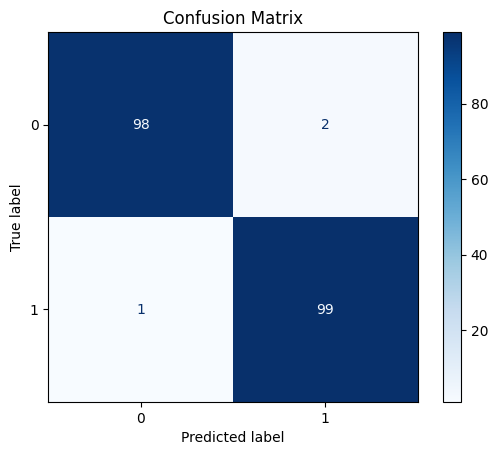

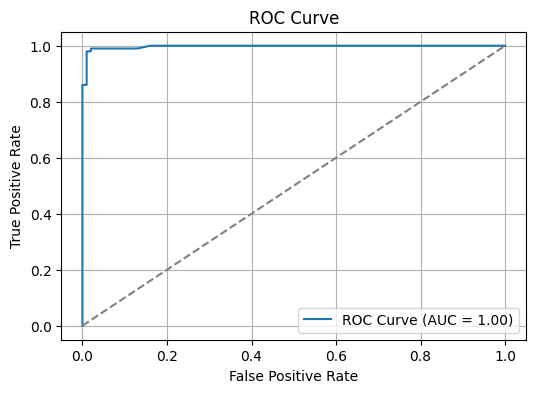

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Export Predictions to CSV

In [20]:
# Add predictions to test set
test_results = X_test.copy()
test_results['Actual'] = y_test.values
test_results['Predicted'] = y_pred
test_results['Risk_Probability'] = y_proba

# Save to CSV
test_results.to_csv('sids_predictions.csv', index=False)
